In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'figure.figsize':(8,6)})
import warnings 
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('nyc_energy_consumption.csv')
df.index = pd.to_datetime(df['timeStamp'])

In [3]:
df.head()

,timeStamp,demand,precip,temp
timeStamp,,,,
2012-01-01 00:00:00,2012-01-01 00:00:00,4937.5,0.0,46.13
2012-01-01 01:00:00,2012-01-01 01:00:00,4752.1,0.0,45.89
2012-01-01 02:00:00,2012-01-01 02:00:00,4542.6,0.0,45.04
2012-01-01 03:00:00,2012-01-01 03:00:00,4357.7,0.0,45.03
2012-01-01 04:00:00,2012-01-01 04:00:00,4275.5,0.0,42.61


In [7]:
df = df.drop(['precip','timeStamp'],axis=1)

array([<AxesSubplot:xlabel='timeStamp'>, <AxesSubplot:xlabel='timeStamp'>],
      dtype=object)

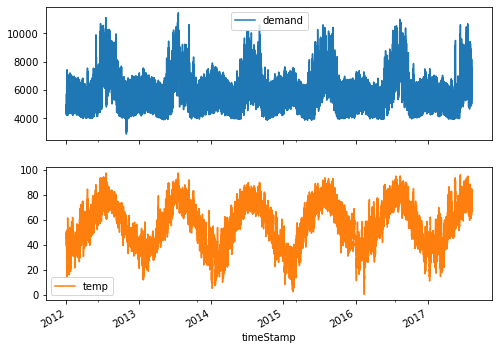

In [21]:
df.plot(subplots=True)

In [23]:
## changing the data into day level
df_daily = df.resample('D').mean()
df_daily.head()

,demand,temp
timeStamp,,
2012-01-01,4954.833333,46.510000
2012-01-02,5302.954167,40.496667
2012-01-03,6095.512500,26.672500
2012-01-04,6336.266667,20.585000
2012-01-05,6130.245833,33.577500


In [26]:
## prophet needs datetime column as 'ds' and the dependent column as 'y'
df_daily_final = df_daily.reset_index().rename({'timeStamp':'ds','demand':'y','temp':'temp'},axis=1)
df_daily_final.head()

,ds,y,temp
0,2012-01-01,4954.833333,46.510000
1,2012-01-02,5302.954167,40.496667
2,2012-01-03,6095.512500,26.672500
3,2012-01-04,6336.266667,20.585000
4,2012-01-05,6130.245833,33.577500


### Null Values
1. WE can see the missing values but prophet takes care of these values
2. but sometimes we need to fill it by busniess knowledege
3. but prophet only take care of 'y' column missing value not other multivariATE values
4. so we need to custom fill nan value in temp and other multivariate columns

In [36]:
df_daily_final.isnull().sum()
df_daily_final.query('temp != temp')

,ds,y,temp


In [34]:
## because temparature not increase gradualy or very fast so we can use forward fill
df_daily_final['temp'] = df_daily_final['temp'].fillna(method='ffill')

In [39]:
## creating the another column as month
df_daily_final['month'] = df_daily_final['ds'].dt.month
df_daily_final.head()

,ds,y,temp,month
0,2012-01-01,4954.833333,46.510000,1
1,2012-01-02,5302.954167,40.496667,1
2,2012-01-03,6095.512500,26.672500,1
3,2012-01-04,6336.266667,20.585000,1
4,2012-01-05,6130.245833,33.577500,1


In [45]:
import plotly.express as px

fig = px.line(df_daily_final,x='ds',y='y',hover_data=['temp','month'],title='NYC Energy Demand')
fig.update_xaxes(rangeslider_visible =True,
                rangeselector = dict(buttons=list([
                    dict(count=1 ,label='1y',step='year',stepmode='backward'),
                    dict(count=3 ,label='3y',step='year',stepmode='backward'),
                    dict(count=5 ,label='5y',step='year',stepmode='backward'),
                    dict(step='all')
                ]))
                )

In [59]:
## here above we are seeing some outliers which present in peak of data in months on july and augst

In [64]:
## here we are grouping the temp with month column and seeing the max , min and avg temparature in every month
df_daily_final[['month','temp']].groupby('month').agg({'temp':{'min','mean','max'}})

temp                      
             max       mean        min
month                                 
1      55.420455  33.432140   9.507917
2      59.360000  34.517758   9.015000
3      67.878333  41.419884  20.291667
4      72.992083  52.600204  33.045833
5      82.576250  62.543994  48.090833
6      86.916667  71.334418  52.405833
7      89.606667  77.595627  66.417083
8      87.426250  75.525947  68.042083
9      84.448750  69.550306  57.274583
10     74.277500  58.642895  42.106250
11     67.606250  47.225638  27.172500
12     64.735000  41.520068  22.429583

### conclusion:
1. here above we can see the 6,7,8 month temp is pretty high and also mean is high
2. so we need to do some feature engineering to feed to model

In [67]:
## here we can temparature and Y features are +ve correlated
df_daily_final.corr()

,y,temp,month
y,1.000000,0.560888,0.087759
temp,0.560888,1.000000,0.353297
month,0.087759,0.353297,1.000000


In [83]:
## here we finding the correlation but where temp > 80 and temp < 80
## because we know when temp rise , demand also rise
above_80_corr = df_daily_final[df_daily_final['temp']>80][['y','temp']].corr()
below_80_corr = df_daily_final[df_daily_final['temp']<80][['y','temp']].corr()
print('Correlation Temp Above 80')
print(above_80_corr)
print('\nCorrelation Temp Below 80')
print(below_80_corr)

Correlation Temp Above 80
             y      temp
y     1.000000  0.552918
temp  0.552918  1.000000

Correlation Temp Below 80
             y      temp
y     1.000000  0.470562
temp  0.470562  1.000000


### Conclusion:
1. since we know the temp above 80 is not modeling properly so creating the new column called summer temp which we feed to model.

In [85]:
def summer_temp(temp):
    if temp > 80:
        return 1
    else:
        return 0

In [86]:
df_daily_final['summer_temp'] = df_daily_final['temp'].apply(summer_temp)

### dividing the months into bins
1. bins means like we assign bins = 3  on month so it divide 12 months in part of 3 ,
2. like (1-4) = 1 bin , (4,8) = 2 bin , (8,12) = 3 bin
3. we use pandas cut function for it

In [97]:
df_daily_final['month_bins'] = pd.cut(df_daily_final['month'],bins=3,labels=False)

In [104]:
df_daily_final.sample(5)

,ds,y,temp,month,summer_temp,month_bins
715,2013-12-16,6255.016667,29.332500,12,0,2
291,2012-10-18,5640.387500,55.727917,10,0,2
1308,2015-08-01,7306.801375,81.123333,8,1,1
831,2014-04-11,5460.500000,60.301250,4,0,0
1109,2015-01-14,6365.968125,24.389167,1,0,0


In [105]:
### train test split 
train = df_daily_final[(df_daily_final['ds'] >= '2012-01-01') & (df_daily_final['ds'] <= '2017-04-30')]
test = df_daily_final[df_daily_final['ds'] > '2017-04-30']

### training model

In [109]:
from fbprophet import Prophet
model = Prophet(interval_width=0.95,yearly_seasonality=True)

In [112]:
## because prophet do not take multiple columns it only takes ds and y column.
## for multi columns we use add_regresser method
## prophet is addivtive linear model basically and the extra column it takes as additions regresser .

model.add_regressor('summer_temp',standardize=False)

## some time we need to interaction b/w to variables then we us multiplicative mode
model.add_regressor('month_bins',standardize=False, mode='multiplicative')

In [113]:
model.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [117]:
future = model.make_future_dataframe(periods=len(test)) #104

,ds
2046,2017-08-08
2047,2017-08-09
2048,2017-08-10
2049,2017-08-11
2050,2017-08-12


In [118]:
## for predicating the future value we do not know what is our multivariate column will be
## we are predicating the demand but we need to manualy feed the probiable future value

future['summer_temp'] = df_daily_final['summer_temp']
future['month_bins'] = df_daily_final['month_bins']

In [119]:
future.tail()

,ds,summer_temp,month_bins
2046,2017-08-08,0,1
2047,2017-08-09,0,1
2048,2017-08-10,0,1
2049,2017-08-11,0,1
2050,2017-08-12,0,1


In [120]:
forecast = model.predict(future)

In [121]:
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2046,2017-08-08,7376.406641,6581.540022,8118.174282
2047,2017-08-09,7387.201289,6552.323310,8193.057460
2048,2017-08-10,7357.497487,6577.304717,8101.487798
2049,2017-08-11,7307.263418,6541.024746,8050.258103
2050,2017-08-12,6726.363455,5991.298575,7439.617541


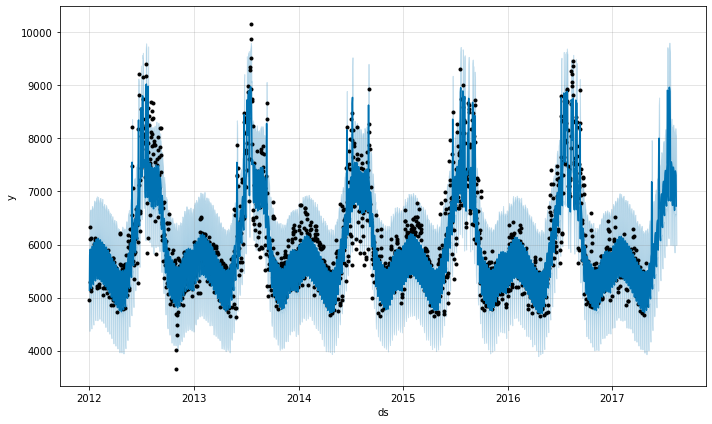

In [122]:
fig = model.plot(forecast)

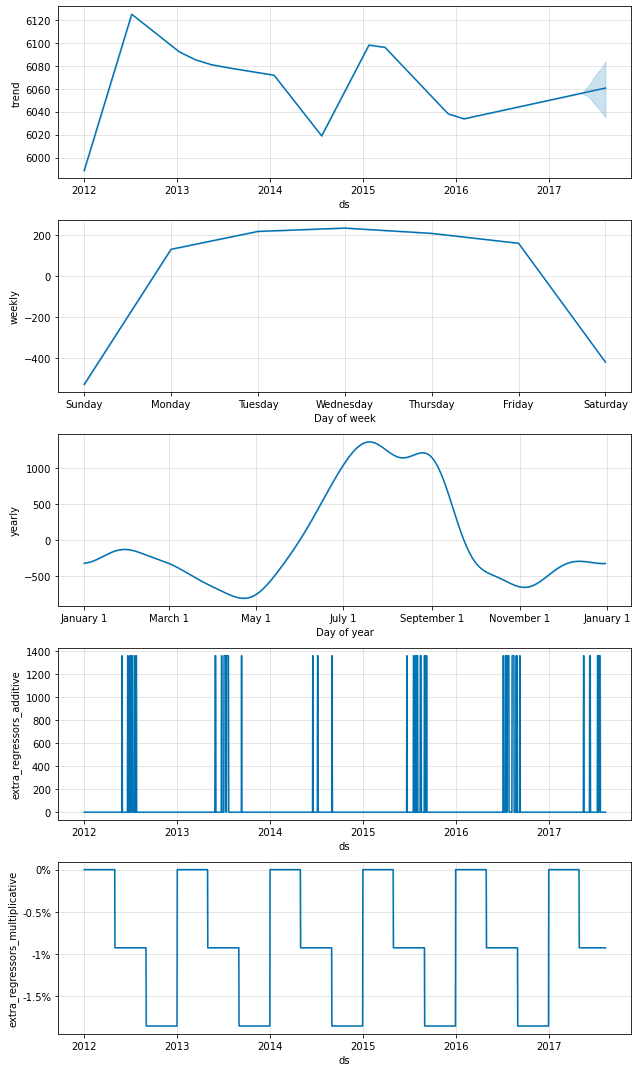

In [131]:
fig2 = model.plot_components(forecast)

In [132]:
## cross validation
from fbprophet.diagnostics import cross_validation , performance_metrics
cv_Result = cross_validation(model=model , initial='731 days',horizon='365 days')

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-05-01 00:00:00 and 2016-04-30 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

In [135]:
performance_metrics(cv_Result)

,horizon,mse,rmse,mae,mape,mdape,coverage
0,36 days 12:00:00,203706.204840,451.338238,352.608713,0.062538,0.051537,0.895604
1,37 days 00:00:00,209754.996350,457.990171,359.590764,0.063716,0.052701,0.890110
2,37 days 12:00:00,211007.054695,459.355042,361.929745,0.064109,0.053764,0.890110
3,38 days 00:00:00,215090.481158,463.778483,365.952816,0.064517,0.054092,0.884615
4,38 days 12:00:00,217294.074439,466.148125,369.826176,0.065133,0.055147,0.884615
...,...,...,...,...,...,...,...
653,363 days 00:00:00,152220.128295,390.153980,329.148285,0.060273,0.060875,0.978022
654,363 days 12:00:00,152733.840337,390.811771,329.171659,0.060278,0.060875,0.978022
655,364 days 00:00:00,155888.652826,394.827371,331.903789,0.060981,0.061061,0.972527
656,364 days 12:00:00,155401.364264,394.209797,330.627365,0.060767,0.061025,0.972527


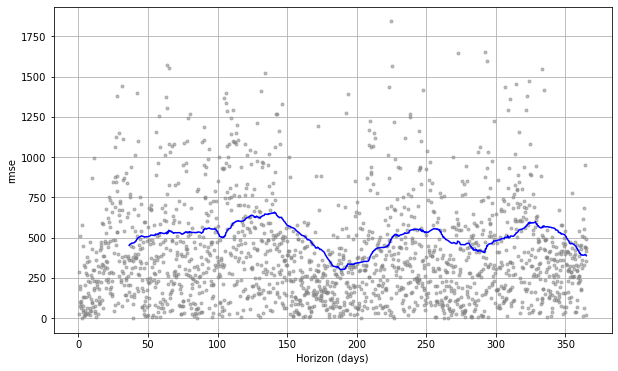

In [136]:
from fbprophet.plot import plot_cross_validation_metric
fig3 = plot_cross_validation_metric(cv_Result,metric='rmse')